<a href="https://colab.research.google.com/github/farhan1503001/Human-Image-Segmentation-/blob/main/PyTorch_ImageSegmentation_Using_DeepLabV3_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     |████████████████████████████████| 88 kB 4.4 MB/s 
     |████████████████████████████████| 376 kB 37.7 MB/s 
     |████████████████████████████████| 58 kB 2.9 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=7ec8ebcb2999bc0a694f16004c490337cb12c5ecc9f14c1ae26eb97fccfb06b6
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=02f30f72daaddf3066f0a79f04a334aa4e9135979b06927d65f511d44450f499
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-24xg2qec
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-24xg2qec
   

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 16.60 MiB/s, done.
Resolving deltas: 100% (3/3), done.


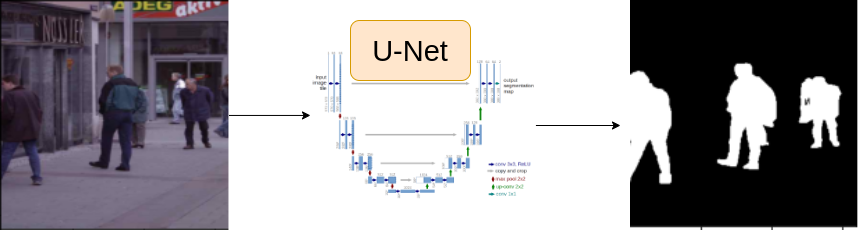

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE='/content/Human-Segmentation-Dataset-master/train.csv'
data_dir='/content/'
IMAGE_SIZE=320
Encoder='timm-efficientnet-b0'
weights='imagenet'
Batch_size=16
DEVICE='cuda'

In [6]:
data=pd.read_csv(CSV_FILE)
data.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


**Reading Images**

In [7]:
index=20
image_path=data.iloc[index].images
mask_path=data.iloc[index].masks
image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255.0

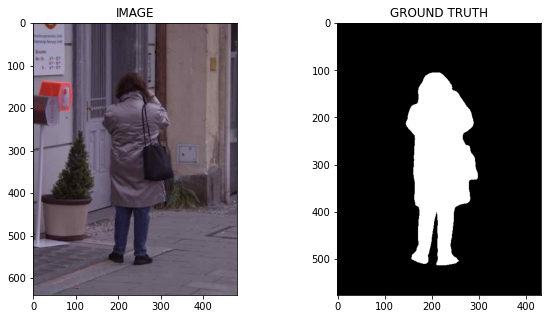

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_frame,test_frame=train_test_split(data,test_size=0.2,random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as augmentar

In [11]:
def training_augment():
  return augmentar.Compose(
      [
       augmentar.Resize(IMAGE_SIZE,IMAGE_SIZE),
       augmentar.HorizontalFlip(p=0.5),
       augmentar.VerticalFlip(p=0.5)
      ]
  )
def validation_augment():
  return augmentar.Compose(
      [
       augmentar.Resize(IMAGE_SIZE,IMAGE_SIZE)
      ]
  )

# Task 4 : Create Custom Dataset 

In [12]:
from torch.utils.data.dataset import Dataset

In [13]:
#Now creating segmentation dataset
class SegmentarSet(Dataset):
  def __init__(self,df,augmentations):
    self.dataframe=df
    self.augmentations=augmentations
  def __len__(self):
    return len(self.dataframe)
  def __getitem__(self, index):
    row=self.dataframe.iloc[index]

    image_path=row.images
    mask_path=row.masks
    #Now reading
    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    mask=np.expand_dims(mask,axis=-1)

    if self.augmentations:
      data=self.augmentations(image=image,mask=mask)
      image=data['image']
      mask=data['mask']
    #Now reshaping for pytorch
    image=np.transpose(image,(2,0,1)).astype(np.float32)
    mask=np.transpose(mask,(2,0,1)).astype(np.float32)
    #Now we are converting image to tensor
    image=torch.Tensor(image)/255.0
    mask=torch.round(torch.Tensor(mask)/255.0)

    return image,mask


In [14]:
#Now finally creating our custom dataset
trainset=SegmentarSet(train_frame,training_augment())
validset=SegmentarSet(test_frame,validation_augment())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


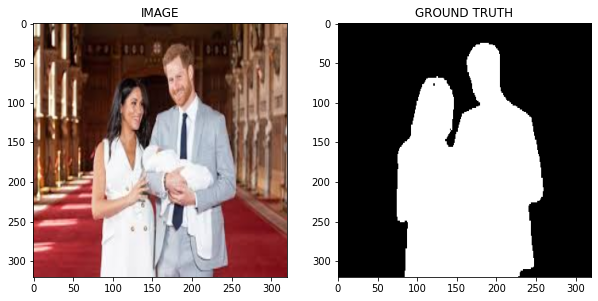

In [16]:
#now we want to visualize the image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
index=20
image,mask=trainset[index]      
ax1.set_title('IMAGE')
ax1.imshow(image.permute(1,2,0).squeeze(),cmap='gray')

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask.permute(1,2,0).squeeze(),cmap ='gray')

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data.dataloader import DataLoader

In [18]:
traindata_loader=DataLoader(trainset,batch_size=Batch_size,shuffle=True)
validdata_loader=DataLoader(validset,batch_size=Batch_size,shuffle=False)

In [19]:
print(f"Number of Batches in Train Loader {len(traindata_loader)}")
print(f"Number of Batches in Test Loader {len(validdata_loader)}")

Number of Batches in Train Loader 15
Number of Batches in Test Loader 4


In [20]:
#Now just seeing the size of first batch
for image,mask in traindata_loader:
  break
print(f"One batch Image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

One batch Image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp 
from segmentation_models_pytorch.losses import DiceLoss
torch.cuda.empty_cache()

In [22]:
#Now creating our segmentation model class
class SegmentingModel(nn.Module):
  def __init__(self) -> None:
      super(SegmentingModel,self).__init__()
      self.arc=smp.DeepLabV3Plus(encoder_name='resnet34',
                        encoder_weights=weights,
                        in_channels=3,
                        classes=1,
                        activation=None
                        )
  def forward(self,image,mask=None):
    logits=self.arc(image)
    if mask!=None:
      loss1=DiceLoss(mode='binary')(logits,mask)
      loss2=nn.BCEWithLogitsLoss()(logits,mask)
      return logits,loss1+loss2
    return logits

In [23]:
model=SegmentingModel()
model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

SegmentingModel(
  (arc): DeepLabV3Plus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         

# Task 7 : Create Train and Validation Function 

In [24]:
#Now creating a training function
def training_function(dataloader,model,optimizer):
  model.train()
  train_loss=0.0
  for image,mask in dataloader:
    image=image.to(DEVICE)
    mask=mask.to(DEVICE)

    optimizer.zero_grad()
    logits,loss=model(image,mask)
    loss.backward()
    optimizer.step()
    train_loss+=loss.item()
  return train_loss/len(dataloader)

In [25]:
#Now creating a training function
def eval_function(dataloader,model):
  model.eval()
  eval_loss=0.0
  with torch.no_grad():
    for image,mask in dataloader:
      image=image.to(DEVICE)
      mask=mask.to(DEVICE)

      logits,loss=model(image,mask)
      eval_loss+=loss.item()
  return eval_loss/len(dataloader)

# Task 8 : Train Model

In [26]:
#Now defining optimizer
optimizer=torch.optim.Adam(model.parameters(),lr=0.003)
EPOCHS=30

In [27]:
best_validation_loss=np.Inf
for i in range(EPOCHS):
  train_loss=training_function(traindata_loader,model,optimizer)
  valid_loss=eval_function(validdata_loader,model)
  if best_validation_loss>valid_loss:
    torch.save(model.state_dict(),"Best_Model+EFF.pt")
    print("Model Saved")
    best_validation_loss=valid_loss
  print(f"Epoch {i+1} Train Loss {train_loss} Validation Loss {valid_loss}")

Model Saved
Epoch 1 Train Loss 1.0249725182851155 Validation Loss 10.96567177772522
Model Saved
Epoch 2 Train Loss 0.7981625119845073 Validation Loss 3.959275960922241
Model Saved
Epoch 3 Train Loss 0.7583975195884705 Validation Loss 1.3571212887763977
Model Saved
Epoch 4 Train Loss 0.7178827246030172 Validation Loss 1.2647667974233627
Model Saved
Epoch 5 Train Loss 0.6959012826283772 Validation Loss 0.6980206370353699
Epoch 6 Train Loss 0.6772878646850586 Validation Loss 0.755129024386406
Epoch 7 Train Loss 0.708974568049113 Validation Loss 0.7366318106651306
Epoch 8 Train Loss 0.6438467939694722 Validation Loss 0.714537963271141
Epoch 9 Train Loss 0.6167393684387207 Validation Loss 0.9736916869878769
Epoch 10 Train Loss 0.6163023928801219 Validation Loss 0.7740476429462433
Model Saved
Epoch 11 Train Loss 0.5810697317123413 Validation Loss 0.6630308851599693
Epoch 12 Train Loss 0.6052889982859294 Validation Loss 0.6831240355968475
Epoch 13 Train Loss 0.5590759833653768 Validation Loss

# Task 9 : Inference

In [28]:
import helper

In [31]:
index=22
image,mask=validset[index]
#Now loading the model
model.load_state_dict(torch.load('/content/Best_Model+EFF.pt'))
#Now predicting
value=image.to(DEVICE).unsqueeze(0)
value=value.reshape((1,3,320,320))

logits_mask=model(value)
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)*1.0

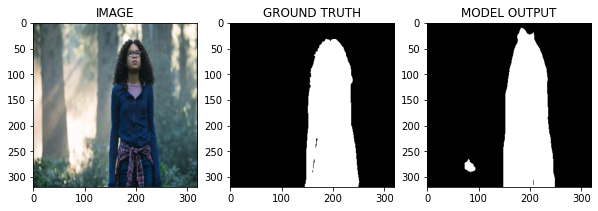

In [32]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))